# Abgabe 4: Statistische Mechanik

**Teammitglieder:** René Zarwel, Matthias Kastenmüller

<br>

Importieren allgemein benötigter Bibliotheken:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import *
import pylab as pylab
import numpy.polynomial.polynomial as poly
import numpy as np
from numpy import *
from numpy.linalg import norm
from scipy.integrate import odeint
import copy
import math
import random
import vpython as vp         # get VPython modules for animation
vec=vp.vector

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Aufgabe 1: Scheiben in einem Quadrat

### a) Simulation mittels Molekulardynamik

In [6]:
def compute_energy(x, v):
    Vkin = 0
    for i in range(len(x)):
        Vkin += 0.5*dot(v[i,:],v[i,:])
    return Vkin

def wall_time(pos_a, vel_a, sigma):
    if vel_a > 0.0:
        del_t = (1.0 - sigma - pos_a) / vel_a
    elif vel_a < 0.0:
        del_t = (pos_a - sigma) / abs(vel_a)
    else:
        del_t = float('inf')
    return del_t

def pair_time(pos_a, vel_a, pos_b, vel_b, sigma):
    del_x = [pos_b[0] - pos_a[0], pos_b[1] - pos_a[1]]
    del_x_sq = del_x[0] ** 2 + del_x[1] ** 2
    del_v = [vel_b[0] - vel_a[0], vel_b[1] - vel_a[1]]
    del_v_sq = del_v[0] ** 2 + del_v[1] ** 2
    scal = del_v[0] * del_x[0] + del_v[1] * del_x[1]
    Upsilon = scal ** 2 - del_v_sq * ( del_x_sq - 4.0 * sigma **2)
    if Upsilon > 0.0 and scal < 0.0:
        del_t = - (scal + math.sqrt(Upsilon)) / del_v_sq
    else:
        del_t = float('inf')
    return del_t

def run(pos, vel, sigma, n_events):
    xHist = []
    vHist = [] 
    singles = [(0, 0), (0, 1), (1, 0), (1, 1), (2, 0), (2, 1), (3, 0), (3, 1)]
    pairs = [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
    t = 0.0
    for event in range(n_events):
        xHist.append(copy.deepcopy(pos))
        vHist.append(copy.deepcopy(vel))
        wall_times = [wall_time(pos[k][l], vel[k][l], sigma) for k, l  in singles]
        pair_times = [pair_time(pos[k], vel[k], pos[l], vel[l], sigma) for k, l in pairs]
        next_event = min(wall_times + pair_times)
        t += next_event
        for k, l in singles: pos[k][l] += vel[k][l] * next_event
        if min(wall_times) < min(pair_times):
            collision_disk, direction = singles[wall_times.index(next_event)]
            vel[collision_disk][direction] *= -1.0
        else:
            a, b = pairs[pair_times.index(next_event)]
            del_x = [pos[b][0] - pos[a][0], pos[b][1] - pos[a][1]]
            abs_x = math.sqrt(del_x[0] ** 2 + del_x[1] ** 2)
            e_perp = [c / abs_x for c in del_x]
            del_v = [vel[b][0] - vel[a][0], vel[b][1] - vel[a][1]]
            scal = del_v[0] * e_perp[0] + del_v[1] * e_perp[1]
            for k in range(2):
                vel[a][k] += e_perp[k] * scal
                vel[b][k] -= e_perp[k] * scal
    VKinHist = []
    xHist = array(xHist)
    vHist = array(vHist)
    for i,ti in enumerate(xHist):
        Vkin = compute_energy(xHist[i,:,:], vHist[i,:,:])
        VKinHist.append(Vkin)
    return xHist, vHist, array(VKinHist)

def plotMD(xhist, vhist, vkinHist):
    # Plot der Daten
    figure(figsize=(15,15))
    subplot(221)
    c = []
    for i in range(xhist.shape[1]):
        c.append(cm.rainbow((float(i)/xhist.shape[1])))
        plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
        plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
        plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
    axis('equal')
    title('Trajektorien')
    xlabel('$x$')
    ylabel('$y$')
    grid(True)
    legend( [Line2D([],[], linestyle='-', color='k'),
             Line2D([],[], linestyle='', marker='o', color='k'),
             Line2D([],[], linestyle='', marker='s', color='k')],
            ["Verlauf",
             "$x(t=0)$",
             r'$x(t=t_{end})$'],
            numpoints=1)

    subplot(222)
    hist(xhist[:,:,0], color=c)
    title('Histogram')
    xlabel('$x$')
    ylabel('Anzahl')  
    
    subplot(223)
    axes = plt.gca()
    axes.set_xlim([0,len(vkinHist)])
    axes.set_ylim([0,2*max(vkinHist)])
    plot(range(len(vkinHist)), vkinHist, label='Kinetisch')
    grid(True)
    xlabel('Event')
    ylabel('Energie')
    title('Energie pro Event')
    legend()

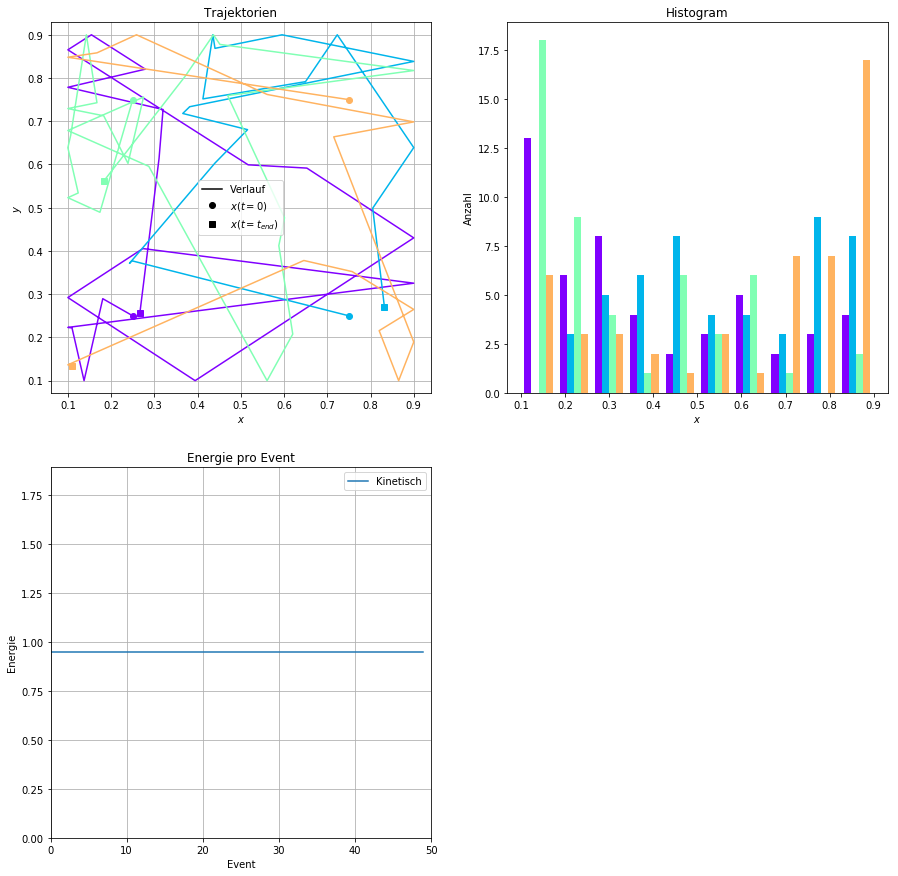

In [7]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

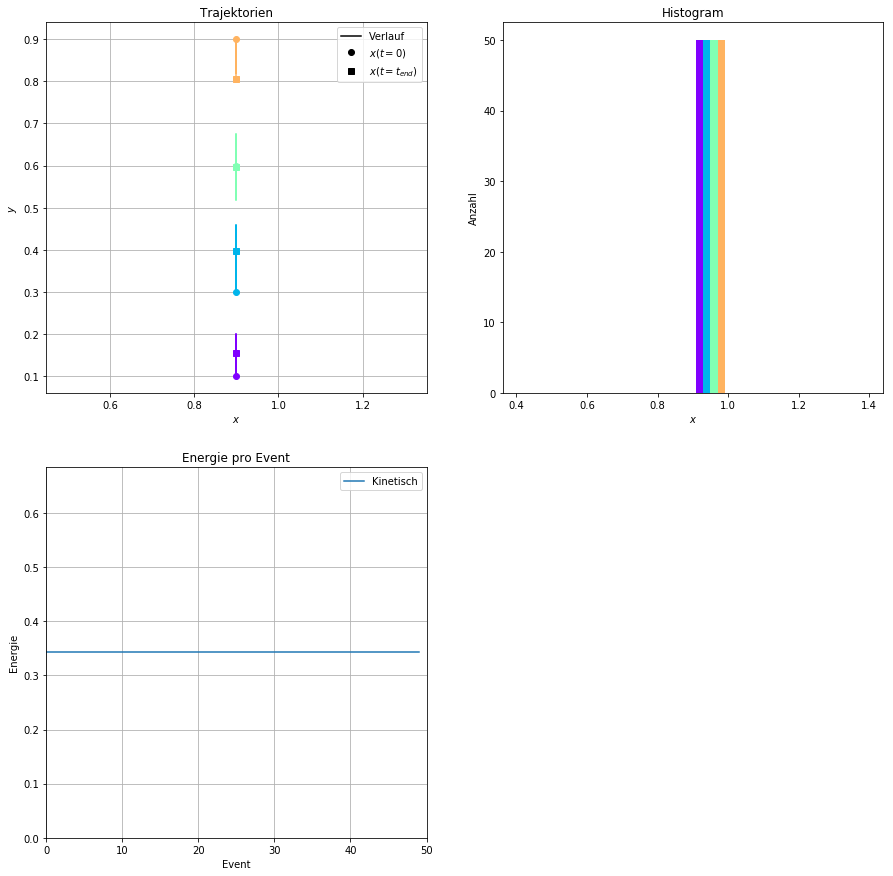

In [23]:
pos = [[0.9, 0.1], [0.9, 0.3], [0.9, 0.6], [0.9, 0.9]]
vel = [[0, 0.12], [0, 0.18], [0, -0.79], [0, 0.1177]]
sigma = 0.1
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

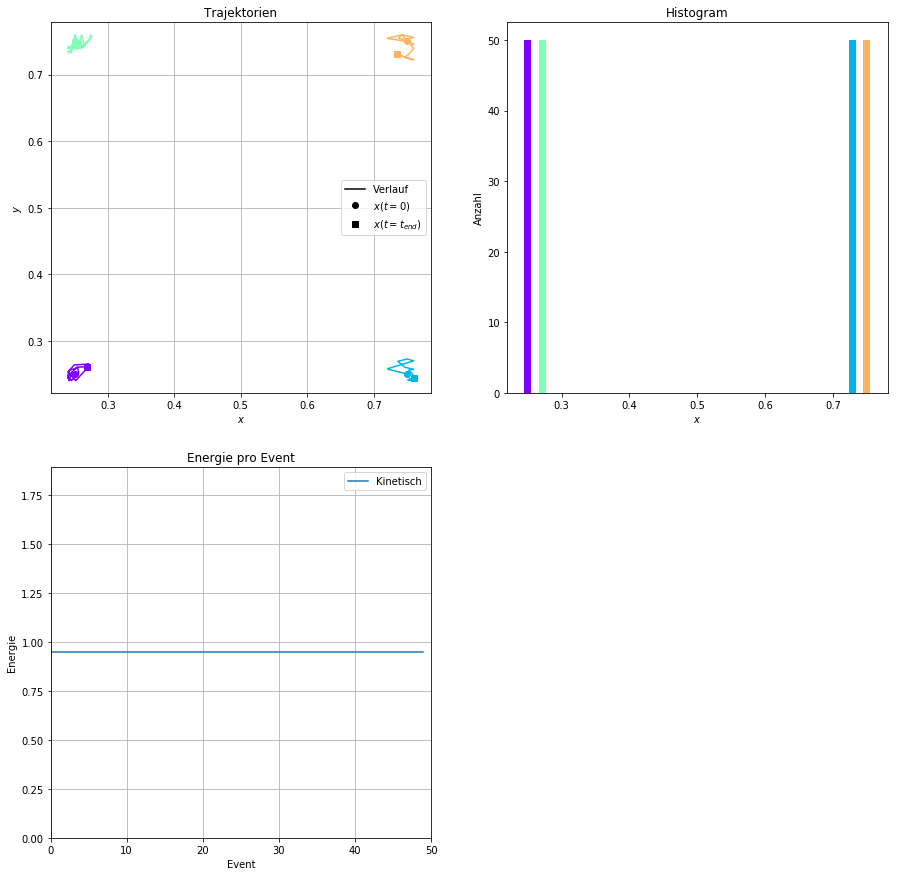

In [24]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.24
n_events = 50
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

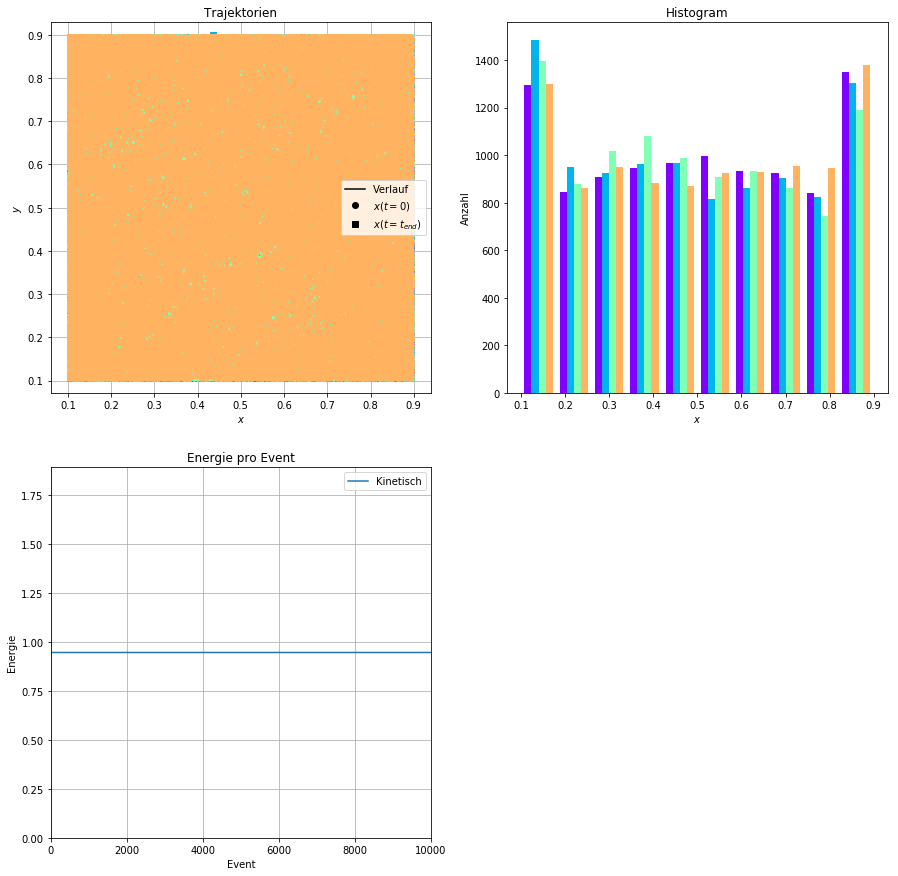

In [50]:
pos = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
vel = [[-0.21, 0.12], [-0.71, 0.18], [-0.23, -0.79], [-0.78, 0.1177]]
sigma = 0.1
n_events = 10000
xhist, vhist, vkinHist  = run(pos, vel, sigma, n_events)

plotMD(xhist, vhist, vkinHist)

### b) Simulation mittels Markov-Monte-Carlo-Algorithmus

Text(0,0.5,'Anzahl')

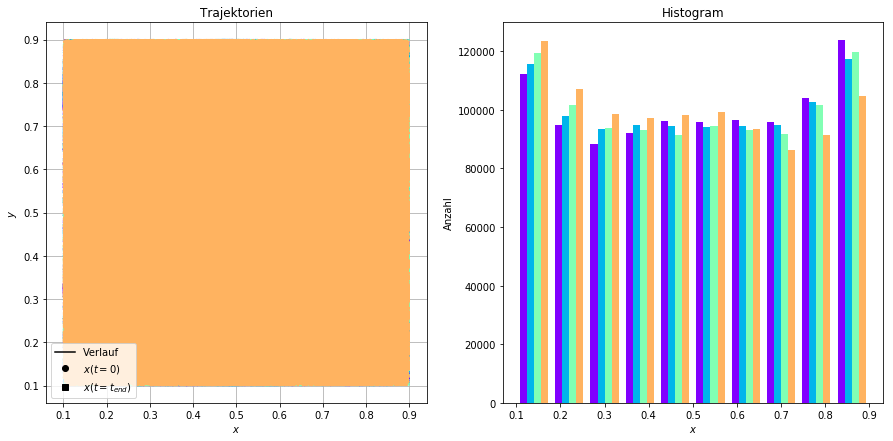

In [53]:
L = [[0.25, 0.25], [0.75, 0.25], [0.25, 0.75], [0.75, 0.75]]
sigma = 0.1
sigma_sq = sigma ** 2
delta = 0.1
n_steps = 1000000
xhist = []
for steps in range(n_steps):
    a = random.choice(L)
    b = [a[0] + random.uniform(-delta, delta), a[1] + random.uniform(-delta, delta)]
    min_dist = min((b[0] - c[0]) ** 2 + (b[1] - c[1]) ** 2 for c in L if c != a)
    box_cond = min(b[0], b[1]) < sigma or max(b[0], b[1]) > 1.0 - sigma
    if not (box_cond or min_dist < 4.0 * sigma ** 2):
        a[:] = b
    xhist.append(copy.deepcopy(L))

xhist = array(xhist)
# Plot der Daten
figure(figsize=(15,7))
subplot(121)
c = []
for i in range(xhist.shape[1]):
    c.append(cm.rainbow((float(i)/xhist.shape[1])))
    plot(xhist[0,i,0], xhist[0,i,1],'o', color=c[i])
    plot(xhist[-1,i,0], xhist[-1,i,1],'s', color=c[i])
    plot(xhist[:,i,0], xhist[:,i,1], color=c[i])
axis('equal')
title('Trajektorien')
xlabel('$x$')
ylabel('$y$')
grid(True)
legend( [Line2D([],[], linestyle='-', color='k'),
         Line2D([],[], linestyle='', marker='o', color='k'),
         Line2D([],[], linestyle='', marker='s', color='k')],
        ["Verlauf",
         "$x(t=0)$",
         r'$x(t=t_{end})$'],
        numpoints=1)

subplot(122)
hist(xhist[:,:,0], color=c)
title('Histogram')
xlabel('$x$')
ylabel('Anzahl') 

## Aufgabe 2: Monte-Carlo-Verfahren zur Integration

## Aufgabe 3: Ising-Modell

In [103]:
L = 20
N = L * L
nbr = {i : ((i // L) * L + (i + 1) % L, (i + L) % N,
            (i // L) * L + (i - 1) % L, (i - L) % N) \
                                    for i in range(N)}

def ising(T, nsteps):
    beta = 1.0 / T
    S = [random.choice([1, -1]) for k in range(N)]
    Mag = np.empty(nsteps)
    for step in range(nsteps):
        k = random.randint(0, N - 1)
        delta_E = 2.0 * S[k] * sum(S[nn] for nn in nbr[k])
        if random.uniform(0.0, 1.0) < math.exp(-beta * delta_E):
            S[k] *= -1
        Mag[step] = sum(S)
    return Mag, S;

1.0082321166992188


Text(0.5,1,'Ising: Hohe Temperatur')

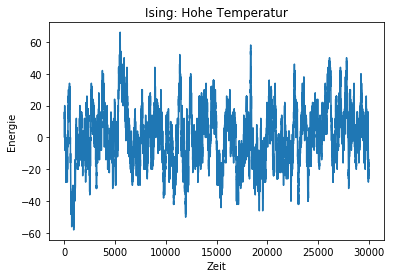

In [104]:
import time
nsteps = 30000
T = 2000

start = time.time()
Mag, S = ising(T, nsteps)
end = time.time()
print(end - start)

plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Hohe Temperatur')

Text(0.5,1,'Ising: Niedrige Temperatur')

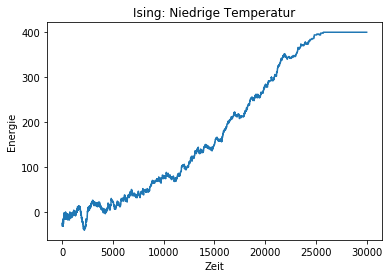

In [83]:
nsteps = 30000
T = 0.1
Mag, S = ising(T, nsteps)
plot(Mag)
xlabel('Zeit')
ylabel('Energie')
title('Ising: Niedrige Temperatur')

TypeError: must be str, not int

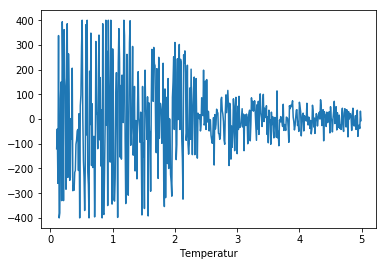

In [84]:
nsteps = 10000
temp_range = arange(0.1, 5, 0.01)
plot (temp_range, [sum(ising(temp, nsteps)[1]) for temp in temp_range])
xlabel('Temperatur')
ylabel('Energie nach ' + nsteps + ' Schritten')
title('Ising: Temperatur/Energie')

## Aufgabe 4: Simulierte Abkühlung und Problem des Handlungsreisenden